# Get interesting insights about your favorite movie using Twitter and Python

## Overview

Every movie buff has a list of favorite movies jotted down in their memory. Have you ever wondered what other people think about your favorite movie? If you have wondered so, you should definitely consider analyzing tweets on Twitter for the movie. One of the latest movies I watched is an Indian movie named 'Rocketry'. I absolutely loved it. Here is some analysis done using the Twitter API and some interesting libraries in Python for the movie 'Rocketry'.

Disclaimer: All the results and text that you see in the output are not my individual opinion. I am merely mining data.

In [453]:
import os
os.chdir("C:\\Twitter Analysis")
working_dir = os.getcwd()
import tweepy as tw
import pandas as pd
import numpy as np
import sys
import csv
import mysql.connector
from mysql.connector import Error
from mysql.connector import errorcode
from pathlib import Path
from dotenv import load_dotenv
import json
from pandas.io.json import json_normalize
import re
import iplot
import matplotlib.pyplot as plt

In [761]:
# Twitter API Authentication
env_path = Path('.') / 'twitter.env' # Env file
load_dotenv(dotenv_path=env_path)
consumer_key = os.getenv('consumer_key')
consumer_secret = os.getenv('consumer_secret')
access_token = os.getenv('access_token')
access_token_secret = os.getenv('access_token_secret')
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)
# If you get an error __init__() got an unexpected keyword argument 'wait_on_rate_limit_notify', 
# remove wait_on_rate_limit_notify = True

In [455]:
'''Note: If you get an error 'Read-only application cannot POST.', do the following -
1. Go to http://dev.twitter.com/apps and login
2. In the Settings tab, change the Application type to Read, Write and Direct messages
3. In the Reset keys tab, press the Reset button, update the consumer key and secret in your application accordingly.'''


# Defining the search term and the date_since values
search_terms = ['Rocketry', '#Rocketry', '#NambiNarayanan', '#RocketryTheNambiEffect','#RocketryTheFilm','#nambi',
               '#TheNambiEffect']
date_since = "2022-01-01"

In [456]:
def stream_tweets(search_term):
    data = [] # empty list to which tweet_details obj will be added
    counter = 0 # counter to keep track of each iteration
    for tweet in tw.Cursor(api.search_tweets, q='\"{}\" -filter:retweets'.format(search_term), count=100, lang='en', tweet_mode='extended').items():
        tweet_details = {}
        tweet_details['name'] = tweet.user.screen_name
        tweet_details['tweet'] = tweet.full_text
        tweet_details['retweets'] = tweet.retweet_count
        tweet_details['location'] = tweet.user.location
        tweet_details['created'] = tweet.created_at.strftime("%d-%b-%Y")
        tweet_details['followers'] = tweet.user.followers_count
        tweet_details['is_user_verified'] = tweet.user.verified
        data.append(tweet_details)
        
        counter += 1
        if counter == 1000:
            break
        else:
            pass
    if not os.path.exists('data'):
        os.makedirs('data')
                        
    with open('data/{}.json'.format(search_term), 'w') as f:
        json.dump(data, f)
    print('done!')

if __name__ == "__main__":
    print('Starting to stream...')
    for search_term in search_terms:
        stream_tweets(search_term)
    print('finished!')


def clean_tweet(tweet):
    return ' '.join(re.sub('(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)', ' ', tweet).split())

Starting to stream...
done!
done!
done!
done!
done!
done!
done!
finished!


If you get the error message 'ValueError: Expected object or value', it could mean that your JSON is empty. To avoid this, a special handling condition has been added -  os.path.getsize(path1+"\\"+file) > 0

In [461]:
def create_json_df(json_file):
    json_df = pd.read_json(json_file, orient='records')
    if 'tweet' in json_df.columns:
        json_df['clean_tweet'] = json_df['tweet'].apply(lambda x: clean_tweet(x))
        print(len(json_df))
        return json_df

path1 = working_dir + "\\data"
final_df = pd.DataFrame()

for file in os.listdir(path1):
    if os.path.getsize(path1+"\\"+file) > 0:
        print(os.path.getsize(path1+"\\"+file))
        print(file)
        json_dataframe1 = create_json_df(path1+"\\"+file)
        final_df = final_df.append(json_dataframe1)   
    else:
        print('ignored file', file)

12608
#nambi.json
31
289836
#NambiNarayanan.json
753
264543
#Rocketry.json
649
207426
#RocketryTheFilm.json
551
369153
#RocketryTheNambiEffect.json
1000
9934
#TheNambiEffect.json
26
353984
Rocketry.json
1000


In [760]:
print('The dataframe has',len(final_df), 'rows')
final_df = final_df.drop_duplicates(keep='first') # Removing duplicates
print('After removing duplicates, the dataframe has',len(final_df), 'rows')

The dataframe has 4010 rows
After removing duplicates, the dataframe has 3039 rows


# Now, onto some interesting Analysis

## Which of the tweets have the most number of retweets? (Top 10)

As you can see below, duplicates are being removed using the column 'clean_tweet'. You might wonder why this is so. This is because there are instances where the tweet has exactly the same text but the tweet has a URL which is in a different format. As an example, let's assume that we have a tweet ‘Rocketry: The Nambi Effect’\n\nhttps://t.co/lxpRjAONFa
Let's say there's another tweet with the same text but one string in the URL is different - ‘Rocketry: The Nambi Effect’\n\nhttps://t.co/4C8KGt1k88. drop_duplicates will consider these two rows as unique rows. However, clean_tweet strips punctuation and URL strings and so it is more effective in removing duplicates. 

In [463]:
pd.set_option ('display.max_colwidth', 1) # Modifying the width to ensure that the complete string fits within the window
df2 = final_df[['clean_tweet', 'retweets','tweet']]
df2 = df2.nlargest(n=, columns=['retweets'])
df2 = df2.drop_duplicates(subset ='clean_tweet' ,keep='first',ignore_index=True) 
df2.loc[:,['tweet']]

,tweet
740,"Nambi Narayanan: Someone wrote a review for Rocketry complaining Nambi is shown as a Hindu, doing Utsavam &amp; reciting Suprabhatam. I have no shame in saying I am a Hindu. Is it a sin to be Hindu? The problem is their mindset""\n\nAnupama Chopra, @anupamachopra we are looking at you. https://t.co/p9hiGjYsoD"
193,"""I am a Hindu. I have no shame in saying that. Is it a sin to be a Hindu?"", Nambi Narayanan hit out at those who had complained about him being shown as a Hindu in the film. @ActorMadhavan \n#RocketryTheFilm #RocketryTheNambiEffect #NambiNarayanan \n https://t.co/3JjOgEdM74"
554,"#Rocketry running to packed shows in Melbourne, well done @ActorMadhavan, who said rocket science was easy! You have beautifully shown every step of what was involved. more power to you!"
18,"⭐ #IMDB: 9.3 rating\n⭐ #RottenTomatoes: 69% Tomatometer\n⭐ #BookMyShow: 96%\n\n#Rocketry: #TheNambiEffect is enjoying tremendous word of mouth, even one week after release... The glowing word of mouth is converting into footfalls. https://t.co/J6uDj8ZJTR"
350,From the Seven hills to the Golden temple. The blessings continue .🚀🚀🚀❤️❤️🙏🙏 #Rocketrythefilm https://t.co/4C8KGt1k88
300,'Sometimes a man wronged is a nation wronged' - The tag line of #ROCKETRY - THE NAMBI EFFECT stands true to every word. Kudos to @ActorMadhavan for this brilliant film. It is a must watch. Justice will elude India till the time the foreign hand is not unmasked.
625,"Dream June - July for @Suriya_offl with back to back fruitful projects and associations 👌\n\n#Vikram &amp; #Rocketry (as an actor rocking in special appearances)\n\n#Gargi (as the presenter giving his 2D brand value to a richly deserving, bold, powerful film)"
713,‘Is it a sin to be a Hindu’: Nambi Narayanan reacts to complaints of his portrayal as a Hindu in his biopic ‘Rocketry: The Nambi Effect’\n\nhttps://t.co/lxpRjAONFa
981,Tracking the landing of a Free falling Falcon 9. Reusability is the holy grail of rocketry. @elonmusk https://t.co/YxYW88xiya
204,"""Is it a sin to be Hindu?""asks Nambi Narayan to those who have criticized ‘Rocketry""for showing him performing Hindu rituals. For yrs, through cinema, education, &amp; media being Hindu has been portrayed as a sin. This is the mechanism you see by which Hindus have been made secular."


# What are people's emotions after watching the movie?

The above question is going to be answered by Sentiment Analysis. As you might have seen, Sentiment Analysis has been explained in many blogs and tutorials and is used in many different ways. There are a plethora of libraries available for Sentiment Analysis and each of them has its own algorithm and corresponding accuracies. Having used different libraries for sentiment analysis, I have realized that often times, using different libraries and creating an ensemble is more effective than using individual sentiment analysis libraries. However, in this case, I am just going to go ahead with just one library in the interest of time.  

In [522]:
from textblob import TextBlob

In [523]:
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

final_df['subjectivity'] = final_df['tweet'].apply(get_subjectivity)

#final_df['polarity'] = 
#final_df['tweet'].apply(get_polarity)

In [499]:
final_df

,name,tweet,retweets,location,created,followers,is_user_verified,clean_tweet,Polarity,Final Sentiment,subjectivity
0,rmk1205,@pnrazdan Same court could not hear case of scientist #Nambi for years. #courtsfailingindia,0,"Mumbai, India",19-Jul-2022,51,False,Same court could not hear case of scientist Nambi for years courtsfailingindia,0.000000,Neutral,0.125000
1,sharemyviews1,@rishibagree #nambi sir we are proud of you\n\nAt the same time ashamed and sorry for you as a nation for the way you and ur family was treated \n\nPl forgive us \n🙏🙏🙏🙏\n\n@ActorMadhavan \nThanks for bringing this story before the nation #Rocketry \n\nNever forget \n\nAnd never ever repeat,0,India That Is भारत/महाराष्ट्,19-Jul-2022,210,False,nambi sir we are proud of you At the same time ashamed and sorry for you as a nation for the way you and ur family was treated Pl forgive us Thanks for bringing this story before the nation Rocketry Never forget And never ever repeat,0.125000,Positive,0.581250
2,hemantkumarvasa,"@NambiNOfficial \nYes ,\nBeing Hindu is a crime in "" Hindustan "" .\nDid you not learn after everything that happened in past ?\nMore #Nambi shall be created once the current government is out of power . https://t.co/bqVgVQnKTJ",0,,18-Jul-2022,27,False,Yes Being Hindu is a crime in Hindustan Did you not learn after everything that happened in past More Nambi shall be created once the current government is out of power,0.083333,Positive,0.383333
3,DivyanshuVishen,Can't thank you by words sir @ActorMadhavan for the truth which you shown in your movie #RocketryTheNambiEffect. The youth should know what patriotism and courage means. Over and above the great #nambi sir will always be inspiration for us.\nThank you.,5,Jaipur,18-Jul-2022,25,False,Can t thank you by words sir for the truth which you shown in your movie RocketryTheNambiEffect The youth should know what patriotism and courage means Over and above the great nambi sir will always be inspiration for us Thank you,0.400000,Positive,0.425000
4,kautilyatv,"@poovannan_g @realitycheckind One more time I will ask “Where is the proof #Nambi stood by AMN ?” Which part of this article addresses the above question? Still fee, hard to believe a #Mudaliar, that too well read space scientist, backing a #Abraham. But pls prove me wrong. Also, where is AMN support for NN?",0,"Chennai, India",18-Jul-2022,143,False,g One more time I will ask Where is the proof Nambi stood by AMN Which part of this article addresses the above question Still fee hard to believe a Mudaliar that too well read space scientist backing a Abraham But pls prove me wrong Also where is AMN support for NN,-0.072917,Negative,0.510417
...,...,...,...,...,...,...,...,...,...,...,...
995,ankitaail1995,Definitely do no agree with the review. \n\nRocketry is a must watch movie!!! https://t.co/cCxtIMPtqk,0,India,16-Jul-2022,266,False,Definitely do no agree with the review Rocketry is a must watch movie,0.000000,Neutral,0.500000
996,shashigholap,"@ActorMadhavan \nMadhavan sir, Rocketry movies watch today. Very good movie.\n But most speak in English\n No Hindi translation on screen.\n I did not understand a some word.",0,"Shirdi, India",16-Jul-2022,36,False,Madhavan sir Rocketry movies watch today Very good movie But most speak in English No Hindi translation on screen I did not understand a some word,0.470000,Positive,0.426667
997,AnimaSonkar,"Please watch this gem “ROCKETRY” by @ActorMadhavan who has put his heart and soul to portray brilliance of rocket scientist Shri Nambi Narayan in addition to his fight against grave injustice.\n\nI am IMPRESSED, MOVED &amp; DEVASTATED all at the same time as the film concludes ❤️💔❤️‍🩹 https://t.co/9olD4U0EJm",5,Prayagraj l New Delhi,16-Jul-2022,25519,False,Please watch this gem ROCKETRY by who has put his heart and soul to portray brilliance of rocket scientist Shri Nambi Narayan in addition to his fight against grave injustice I am IMPRESSED MOVED amp DEVASTATED all at the same time as the film conclude

In the below statement, a new column named 'Final Sentiment' has been created using the polarity values obtained in the previous step. 

In [551]:
import emoji
conditions = [final_df['Polarity']<-0.25, final_df['Polarity']>0.25]
choices = ['Sad/Pensive',  'Happy/Enthralled']
final_df['Final Sentiment'] = np.select(conditions, choices, default='Mixed Emotions')


In [552]:
final_df

,name,tweet,retweets,location,created,followers,is_user_verified,clean_tweet,Polarity,Final Sentiment,subjectivity
0,rmk1205,@pnrazdan Same court could not hear case of scientist #Nambi for years. #courtsfailingindia,0,"Mumbai, India",19-Jul-2022,51,False,Same court could not hear case of scientist Nambi for years courtsfailingindia,0.000000,Mixed Emotions,0.125000
1,sharemyviews1,@rishibagree #nambi sir we are proud of you\n\nAt the same time ashamed and sorry for you as a nation for the way you and ur family was treated \n\nPl forgive us \n🙏🙏🙏🙏\n\n@ActorMadhavan \nThanks for bringing this story before the nation #Rocketry \n\nNever forget \n\nAnd never ever repeat,0,India That Is भारत/महाराष्ट्,19-Jul-2022,210,False,nambi sir we are proud of you At the same time ashamed and sorry for you as a nation for the way you and ur family was treated Pl forgive us Thanks for bringing this story before the nation Rocketry Never forget And never ever repeat,0.125000,Mixed Emotions,0.581250
2,hemantkumarvasa,"@NambiNOfficial \nYes ,\nBeing Hindu is a crime in "" Hindustan "" .\nDid you not learn after everything that happened in past ?\nMore #Nambi shall be created once the current government is out of power . https://t.co/bqVgVQnKTJ",0,,18-Jul-2022,27,False,Yes Being Hindu is a crime in Hindustan Did you not learn after everything that happened in past More Nambi shall be created once the current government is out of power,0.083333,Mixed Emotions,0.383333
3,DivyanshuVishen,Can't thank you by words sir @ActorMadhavan for the truth which you shown in your movie #RocketryTheNambiEffect. The youth should know what patriotism and courage means. Over and above the great #nambi sir will always be inspiration for us.\nThank you.,5,Jaipur,18-Jul-2022,25,False,Can t thank you by words sir for the truth which you shown in your movie RocketryTheNambiEffect The youth should know what patriotism and courage means Over and above the great nambi sir will always be inspiration for us Thank you,0.400000,Happy/Enthralled,0.425000
4,kautilyatv,"@poovannan_g @realitycheckind One more time I will ask “Where is the proof #Nambi stood by AMN ?” Which part of this article addresses the above question? Still fee, hard to believe a #Mudaliar, that too well read space scientist, backing a #Abraham. But pls prove me wrong. Also, where is AMN support for NN?",0,"Chennai, India",18-Jul-2022,143,False,g One more time I will ask Where is the proof Nambi stood by AMN Which part of this article addresses the above question Still fee hard to believe a Mudaliar that too well read space scientist backing a Abraham But pls prove me wrong Also where is AMN support for NN,-0.072917,Mixed Emotions,0.510417
...,...,...,...,...,...,...,...,...,...,...,...
995,ankitaail1995,Definitely do no agree with the review. \n\nRocketry is a must watch movie!!! https://t.co/cCxtIMPtqk,0,India,16-Jul-2022,266,False,Definitely do no agree with the review Rocketry is a must watch movie,0.000000,Mixed Emotions,0.500000
996,shashigholap,"@ActorMadhavan \nMadhavan sir, Rocketry movies watch today. Very good movie.\n But most speak in English\n No Hindi translation on screen.\n I did not understand a some word.",0,"Shirdi, India",16-Jul-2022,36,False,Madhavan sir Rocketry movies watch today Very good movie But most speak in English No Hindi translation on screen I did not understand a some word,0.470000,Happy/Enthralled,0.426667
997,AnimaSonkar,"Please watch this gem “ROCKETRY” by @ActorMadhavan who has put his heart and soul to portray brilliance of rocket scientist Shri Nambi Narayan in addition to his fight against grave injustice.\n\nI am IMPRESSED, MOVED &amp; DEVASTATED all at the same time as the film concludes ❤️💔❤️‍🩹 https://t.co/9olD4U0EJm",5,Prayagraj l New Delhi,16-Jul-2022,25519,False,Please watch this gem ROCKETRY by who has put his heart and soul to portray brilliance of rocket scientist Shri Nambi Narayan in addition to his fight against grave injustice I am IMPRESSED MOVED amp DEVA

In [553]:
tweet_counts = final_df['Final Sentiment'].value_counts()
tweet_counts

Mixed Emotions      2252
Happy/Enthralled    1622
Sad/Pensive         136 
Name: Final Sentiment, dtype: int64

<AxesSubplot:>

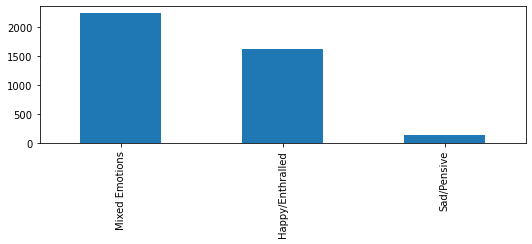

In [554]:
final_df['Final Sentiment'].value_counts(sort=True).nlargest(10).plot.bar()

## What are comments that reflect viewers being Happy/Enthralled? (Top 10 Comments)

In [549]:
pd.set_option ('display.max_colwidth', 3)
happy_df = final_df[(final_df['Final Sentiment']=='Happy/Enthralled')]
happy_df['tweet'].head(n=10)

3     Can't thank you by words sir @ActorMadhavan for the truth which you shown in your movie #RocketryTheNambiEffect. The youth should know what patriotism and courage means. Over and above the great #nambi sir will always be inspiration for us.\nThank you.                                                    
6     @ActorMadhavan sir thank you for showing us wht #Nambi sir has 2 face 4 loving his own country....jst imagine position of Indian in SpaceTech if Nambi Sir ws nt backstbbed\nJst wanna say\n#SorryNambiSir🙏 \n#RocketryTheNambiEffect                                                                           
10    @iamsrk thank you sir for being a part of #RocketryTheNambiEffect what a film! A must watch for every Indian. @ActorMadhavan thank you for making this film. Glad, happy and proud that filmmakers like you guys do exists. #NambiNarayanan #nambi #ROCKETRY                                                    
13    @ActorMadhavan Just watched #Rocketry . \n"Speechless", is th

## What are some comments that reflect viewers being 'sad/pensive'?

In [550]:
sad_df = final_df[(final_df['Final Sentiment']=='Sad/Pensive')]
sad_df['tweet'].head(n=10)

5     Thank you Sri #nambinarayanan Sir  for your contribution to #BhavyaBharath  🙏We  #Bharathiyas are sorry for all the pain you and your family had to go through …..@ActorMadhavan Sir🙏 hope that this movie makes way for a National Award for you…🙏🙌👏 #RocketryTheNambiEffect https://t.co/5L4HesctsQ           
19    When will the matter of fake case against #NambiNarayanan + others will be solved?\n#treason @ActorMadhavan https://t.co/62MpOc6giR                                                                                                                                                                             
20    What #NambiNarayanan said for rockets am saying for crypto, don't ban an emerging tech, we will go 100 years behind if we ban cryoto, regulate it, can't ban it! #cryptoindia                                                                                                                                   
34    @bhatikamlendra1 @luvsachin @ShefVaidya @Sanju37250937 starte

# What are some mixed emotions?

In [564]:
Mixed_Emotions_df = final_df[(final_df['Final Sentiment']=='Mixed Emotions')]
Mixed_Emotions_df['tweet'].head(n=10)

0     @pnrazdan Same court could not hear case of scientist #Nambi for years. #courtsfailingindia                                                                                                                                                                                                                          
1     @rishibagree #nambi sir we are proud of you\n\nAt the same time ashamed and sorry for you as a nation for the way you and ur family was treated \n\nPl forgive us \n🙏🙏🙏🙏\n\n@ActorMadhavan \nThanks for bringing this story before the nation #Rocketry \n\nNever forget \n\nAnd never ever repeat                   
2     @NambiNOfficial \nYes ,\nBeing Hindu is a crime in " Hindustan " .\nDid you not learn after everything that happened in past ?\nMore #Nambi shall be created once the current government is out of power . https://t.co/bqVgVQnKTJ                                                                                   
4     @poovannan_g @realitycheckind One more time I 

# Sentiment Analysis is done.. What Next?

An interesting library that can be used for text that has hashtags and emoticons is 'Advertools'. Below, we exploit 'Advertools' powerful and fun modules to uncover some pretty cool insights.

## What are some emoticons (Emojis) that have been used in the Tweets?

In [510]:
import advertools as adv
emoji_summary = adv.extract_emoji(final_df['tweet'])
Emojis_used_in_tweets = pd.DataFrame.from_dict(emoji_summary['top_emoji'])

<class 'pandas.core.frame.DataFrame'>


In [615]:
pd.set_option ('display.width', 100)
Emojis_used_in_tweets.columns = ['Emoticon', 'Count']
Emojis_used_in_tweets.style.set_table_attributes('style="font-size: 50px"')
Emojis_used_in_tweets[Emojis_used_in_tweets['Count']>35] #Only display emoticons that have a count greater than 35

,Emoticon,Count
0,🙏,435
1,❤️,318
2,✨,301
3,🔥,241
4,🇮🇳,177
5,🚀,146
6,👏,139
7,⚔️,134
8,🙏🏻,92
9,👌,75


# What are the hashtags most commonly used in the Tweets?

In [627]:
pd.set_option ('display.width', 200)
hashtag_summary = adv.extract_hashtags(final_df['tweet'])
Hashtag_used_in_tweets = pd.DataFrame(hashtag_summary['top_hashtags'])
Hashtag_used_in_tweets.columns = ['Emoticon', 'Count']
Hashtag_used_in_tweets.style.set_table_attributes('style="font-size: 11px"')
Hashtag_used_in_tweets[Hashtag_used_in_tweets['Count']>35] #Only display hashtags that have a count greater than 35

,Emoticon,Count
0,#rocketrythenambieffect,1616
1,#rocketry,1463
2,#nambinarayanan,1245
3,#rocketrythefilm,917
4,#rmadhavan,227
5,#vaadivaasal,201
6,#etharkkumthunindhavan,194
7,#suriya,187
8,#rolex,177
9,#suriyasivakumar,174


# # What are some top mentions in tweets?

In [634]:
pd.set_option ('display.width', 200)
mentions_summary = adv.extract_mentions(final_df['tweet'])
Top_Mentions_in_tweets = pd.DataFrame(mentions_summary['top_mentions'])
Top_Mentions_in_tweets.columns = ['Mention', 'Count']
Top_Mentions_in_tweets.style.set_table_attributes('style="font-size: 11px"')
Top_Mentions_in_tweets[Top_Mentions_in_tweets['Count']>30] #Only display mentions that have a count greater than 30

,Mention,Count
0,@actormadhavan,2022
1,@nambinofficial,306
2,@suriya_offl,268
3,@rajsekarpandian,159
4,@iamsrk,84
5,@pradip103,79
6,@isro,66
7,@republic,65
8,@narendramodi,57
9,@indianews_itv,47


# A look at the Mentions Summary

The below provides the number of posts, number of mentions, mentions per post, and unique mentions 

In [637]:
mention_summary = adv.extract_mentions(final_df['tweet'])
mention_summary['overview']

{'num_posts': 4010,
 'num_mentions': 5103,
 'mentions_per_post': 1.272568578553616,
 'unique_mentions': 890}

# # What are some questions that have been posted in the tweets?

In [747]:
question_summary = adv.extract_questions(final_df['tweet'])
final_questions_list = [q for q in question_summary['question_text'] if q!= []]
questions_posed_in_tweets = pd.DataFrame()
for question in final_questions_list:
    questions_posed_in_tweets = questions_posed_in_tweets.append(question)
    questions_posed_in_tweets
questions_posed_in_tweets.columns = ['Question'] # Rename column
questions_posed_in_tweets = questions_posed_in_tweets.drop_duplicates(keep='first') # After removing duplicates, there are 3220 rows
with pd.option_context('display.max_rows', None,):
   print(questions_posed_in_tweets.to_markdown)

<bound method DataFrame.to_markdown of                                                                                                                                  Question                                                                                                                              
0  Did you not learn after everything that happened in past ?                                                                                                                                                                                                          
0  @poovannan_g @realitycheckind One more time I will ask “Where is the proof #Nambi stood by AMN ?                                                                                                                                                                    
1  Which part of this article addresses the above question?                                                                                                              

# # What are some exclamatory remarks that have been posted in the tweets?

In [754]:
exclamations_summary = adv.extract_exclamations(final_df['tweet'])
exclamations_list = [q for q in exclamations_summary['exclamation_text'] if q!= []]
exclamations_posed_in_tweets = pd.DataFrame()
for exclamation in exclamations_list:
    exclamations_posed_in_tweets = exclamations_posed_in_tweets.append(exclamation)
    exclamations_posed_in_tweets
exclamations_posed_in_tweets.columns = ['Exclamation'] # Rename column
exclamations_posed_in_tweets = exclamations_posed_in_tweets.drop_duplicates(keep='first') # After removing duplicates, there are 3220 rows
with pd.option_context('display.max_rows', None,):
   print(exclamations_posed_in_tweets.to_markdown)

<bound method DataFrame.to_markdown of                                                                                                                                 Exclamation                                                                                                                              
0  @iamsrk thank you sir for being a part of #RocketryTheNambiEffect what a film!                                                                                                                                                                                        
0  Prouder now!                                                                                                                                                                                                                                                          
0  Witnessed the story of #NambiNarayanan!!                                                                                                                        